In [4]:
from IPython.display import Image, Audio
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy import signal
import numpy as np
from librosa import load, display  # useful for showing chromagram

# Chromagrams

Chromagrams are a representation of the energy of a signal in terms of its *pitch class* (chroma) content. Therefore, the entire spectrum for a segment of audio is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the octave. **The chroma representation tells us the intensity of each of the 12 distinct musical chroma of the octave at each time frame.**

Chromagrams are very useful in a number of frequency-related tasks, such as key detection, chord dectection, and cover song ID, because they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

Within signal processing, chroma-based audio features are sometimes referred to as "pitch class profiles" --- more on that later.

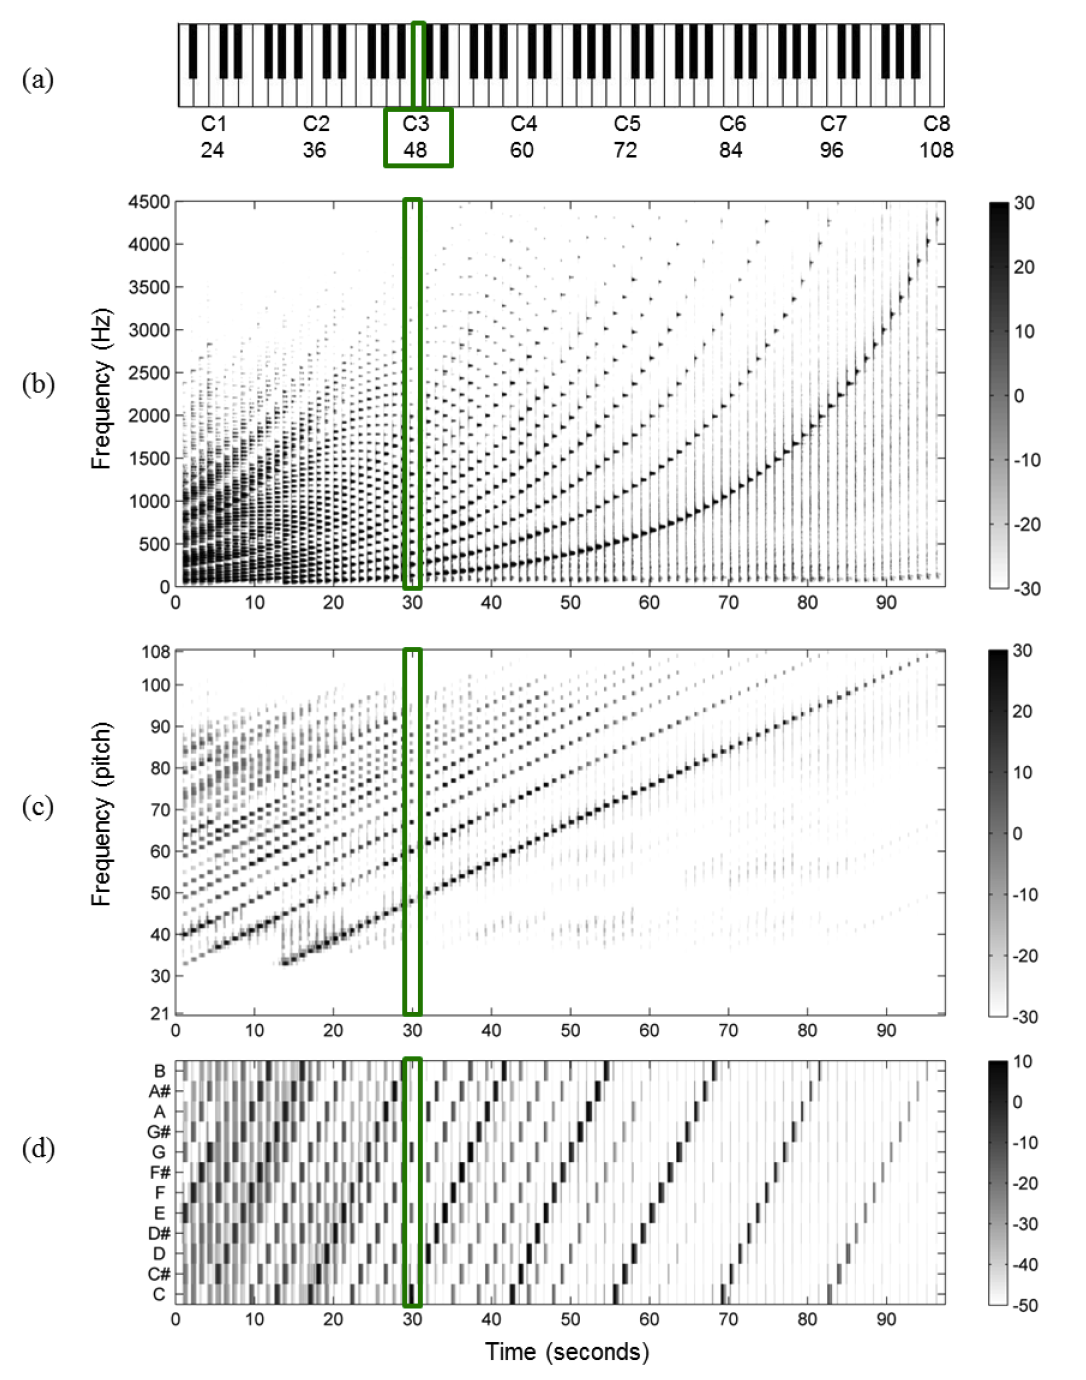

In [5]:
#Full chromatic scale according to three "pitch content" views
Image('../images/chromagram.png', width=400)

To calculate a chromagram, we take a spectrogram and convert the linear frequency axis to a logarithmic one. The signal is decomposed into a large number of equally-spaced frequency bands with center frequencies typically corresponding to the pitches A0 (midi 21) to C8 (midi 108) (or the 88 piano keys), such that each band is a semitone. 

The chroma content is then calculated by summing the *log-frequency* magnitude spectrum across pitches that have an octave relation (e.g., sum A0 + A1 + A2 ... to get the energy for how much "A" there is in a signal.)

Note that different music scholars use the term **pitch class profile** in different ways. When MIR people say "pitch class profiles" they are referring to how much energy in the signal there is at each pitch class. In music perception and cognition, "pitch class profiles" are perceptually derived scales of how well each scale degree "fits" in a tonal key.

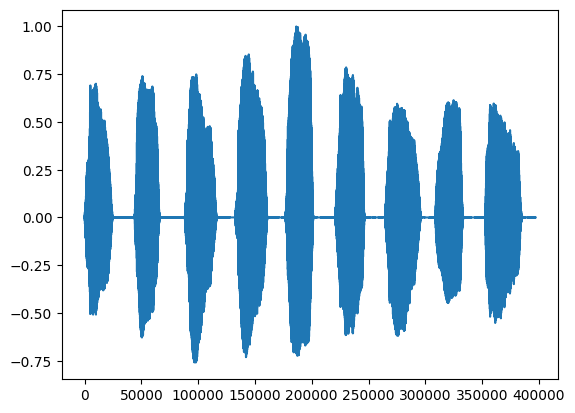

In [6]:
(x, fs) = load('../audio/femaleSingingScale.wav')
(x2, fs2) = load('../audio/piano.wav')
x2 = x2/np.abs(x2.max())

newx = x/np.abs(x.max())
plt.plot(newx)

In [7]:
Audio(newx, rate=fs)

In [8]:
Audio(x2, rate=fs2)

Spectrogram with frequency axis on a log scale:

**Note the capitalized parameter labels in `plt.specgram`**

Text(0.5, 1.0, 'Piano')

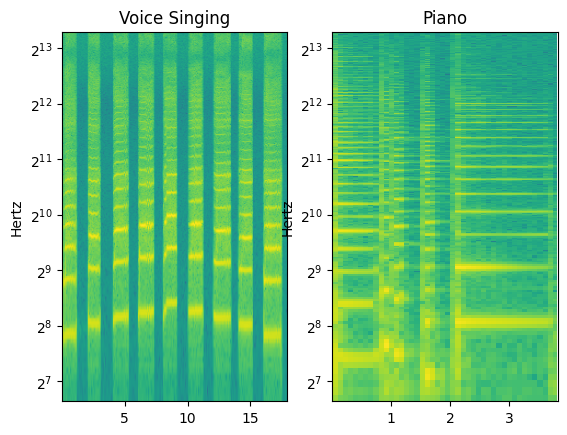

In [9]:
#Vocals

#plt.figure(figsize=(16,5))
ax = plt.subplot(1,2,1)
plt.specgram(newx, NFFT=2048, Fs=22050, mode='magnitude', scale='dB');
ax.set_yscale('log', base=2)#change y axis to log scale
ax.set_ylim(100,10050)#manually set ylimits - default cuts off inappropriately
plt.ylabel('Hertz')
plt.title('Voice Singing')

#Piano
ax2 = plt.subplot(1,2,2)
plt.specgram(x2, NFFT=2048, Fs=22050, mode='magnitude', scale='dB');
ax2.set_yscale('log', base=2)#change y axis to log scale
ax2.set_ylim(100,10050)#manually set ylimits - default cuts off inappropriately
plt.ylabel('Hertz')
plt.title('Piano')

Notice, however, that we have converted the scale of the axis, but not the size of the bins! The bins were computed like a typical STFT such that each frame represented a fixed frequency resolution N/fs Hz wide. This means that the resolution in lower frequency bins is poorer.

In order to build a chromagram with better resolution, ideally we compute a STFT where each bin gets larger and larger (in Hz) to account for the fact that pitch is logarithmic, and we would like to compute a STFT such that each bin is roughly one semitone "pitch" (or 100 cents) wide.

Therefore we assign each spectral coefficient $X(m,k)$ to the pitch with center frequency that is closest to the frequency $F_{coef}(k)$. For each pitch with semitone indices 0:127 (all possible MIDI):

$$P(p)= \{k \in[0:K]:{F_{pitch}(p - 0.5)\leq F_{coef}(k) \lt F_{pitch} (p + 0.5)}\}$$

Where $F_{pitch}(p)$ is defined by the common MIDI to frequency formula:

$$2^{(p-69)/12}*440$$

So for MIDI note $p = 69$ ...

In [10]:
high = 2**(0.5/12)*440
low = 2**(-0.5/12)*440
binsize = high-low #"cutoff frequencies"
print(low,high, "binsize = %s" %binsize)

427.4740541075866 452.8929841231365 binsize = 25.418930015549904


for MIDI note $p = 100$

In [11]:
high = 2**((100.5-69)/12)*440
low = 2**((99.5-69)/12)*440
binsize = high-low
print(low,high, "binsize = %s" %binsize)

2561.9496018022496 2714.2910527179756 binsize = 152.341450915726


The set $P(p)$ consists of all Fourier coefficients that lie within these bounds. In this case, if we did an STFT with a sample rate of 44100 and an analysis window of 4096 samples, then we know that each bin would be ~ 10.7 Hz wide. Thus, the coefficients (k) would be each index multiplied by ~10.7:<br> 
0 = 0<br>
1 = 10.7 Hz <br> 
2 = 21.5 Hz<br>
3 = 32.3 Hz<br>
...<br>
**40 = 430.6 <br>
41 = 438.7 <br>
42 = 449.4<br>**
43 = 460.1<br>

Thus the set $P(p)$ would be the indices that fall within the bandwidth of p = 69, therefore, $p(p) = \{40,41,42\}$ And the spectrogram is computed by summing all coefficients in a similar fasion until we have a spectrogram according to semitone or MIDI values.

Once we have the spectral energy in semitone bins, we simply fold together bins that are 12 semitones apart and sum the content in order to transform into a chromagram.

Fortunately, there are algorithms that can do this for us. We will be using the Librosa package to compute chromagrams, and below you can see two of my approaches to plotting them. 

(Note that, like spectrogram, we tend to (confusingly) use the same word for both the values and the graphs). 

### Librosa functions

Librosa has three *varieties* for computing chromagrams, but we will just be using this one:

* librosa.feature.chroma_stft  

This is the 'basic' chromagram computation as explained (and computed) above.

You must pass either a $y$ value to `feature.chroma_stft` which would be an audio signal, or else an $S$ value, which would be a pre-computed energy (magnitude) spectrum (i.e., STFT via `numpy`)

Package details [here](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html)

In [12]:
from librosa import feature
'''Note that librosa assumes you will downsample, and the default sample rate is 22050
If you want to use an original sample rate of 44.1kHz you must specify the sr rate'''

#creates the cromagram from raw audio
chromagram1 = feature.chroma_stft(y=newx, n_fft=16384,sr=22050, hop_length=2048)
chromagram1 # output = multidimensional array just like STFT

array([[5.05020376e-03, 1.03055397e-02, 1.42550757e-02, ...,
        7.96929970e-02, 9.23421085e-01, 8.97813320e-01],
       [9.86458641e-03, 2.77137347e-02, 4.69661690e-02, ...,
        6.59416765e-02, 9.96713102e-01, 1.00000000e+00],
       [8.54355516e-04, 2.20618187e-03, 4.11766535e-03, ...,
        1.21156491e-01, 1.00000000e+00, 9.38367605e-01],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        4.74044383e-01, 6.26571834e-01, 5.90757966e-01],
       [7.85289109e-02, 8.74100700e-02, 1.15157835e-01, ...,
        2.77887255e-01, 7.77544558e-01, 7.89270699e-01],
       [5.44337276e-03, 4.18499624e-03, 3.23498435e-03, ...,
        1.76065654e-01, 9.64587450e-01, 9.18083787e-01]], dtype=float32)

In [13]:
8192*2


16384

In [14]:
x2 = x2.astype(float) #convert to float for librosa
chromagram2 = feature.chroma_stft(y=x2, n_fft=16384,sr=22050, hop_length=2048)

# scipy.signal.stft(x, fs=1.0, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)[source]¶
# from scipy import stft
# chromagram3 = stft(x2, fs=fs2, nperseg=)

The result is a chroma representation which is a 12-element multidimensional array or matrix, where each row represents the
spectral energy corresponding to one pitch class (i.e. C, C#, D, D#, etc.). Each column represents the subsequent sliding window of each STFT window. (Exactly like regular STFT representation.

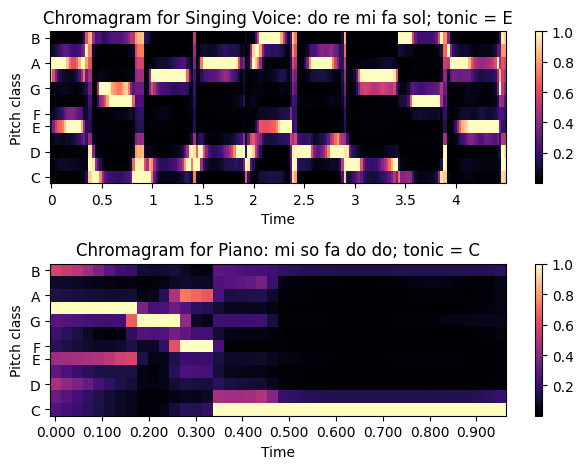

In [15]:
#plt.figure(figsize=(16, 6))
ax = plt.subplot(2,1,1)
display.specshow(chromagram1, y_axis='chroma', x_axis='time') # this creates the graph
plt.colorbar() #this adds the legend
plt.title('Chromagram for Singing Voice: do re mi fa sol; tonic = E')
ax = plt.subplot(2,1,2)
display.specshow(chromagram2, y_axis='chroma', x_axis='time') # this creates the graph
plt.colorbar() #this adds the legend
plt.title('Chromagram for Piano: mi so fa do do; tonic = C')
plt.tight_layout()

You may notice that it doesn't look too good! Although chromagrams are used in a lot of MIR tasks, and over a larger set of data work fairly well, there are some known issues:

1) Generally, higher sounds emit a "cleaner" spectrum than lower sounds. For lower notes, the signal's energy is often contained in higher harmonics. Thus, when we add across pitch class bins, we may estimate the 'wrong' fundamental and instead get the pitch value of the high-energy harmonic(s) (or just a mess).

2) Vocal sounds are known to be problematic for similar reasons, in that often energy is contained in harmonics above the fundamental known as **formants** corresponding to a resonance in the vocal tract. (Also close mic placement can over-emphasize energy in certain frequency bands as well.)

3) Limitation of chroma for multi-part music...

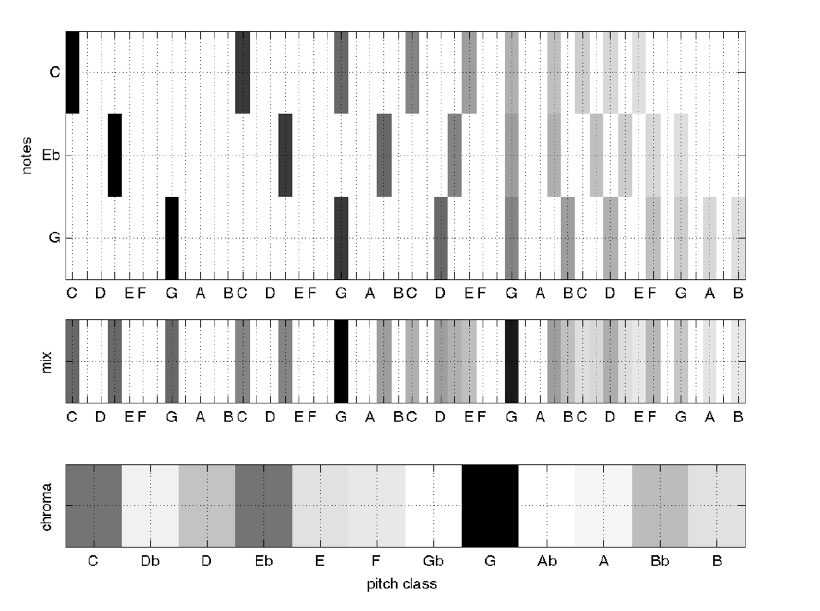

In [16]:
# Top to bottom: semitone-based spectrogram (sideways); combined spectrogram sideways(assume time overlap); chromagram 
Image('../images/chroma_polyphonic.png', embed=True)

The chroma vectors are affected by the strong partials present in the signal. When many events happen over a single window, this can be problematic (overly reductive). Likewise, when louder events mask "harmonically important" quieter events, this can produce misleading chromagram data.